In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from bartpy.bartpy.sklearnmodel import SklearnModel
from tqdm import tqdm

from scipy.special import logit, expit
from scipy.stats import bernoulli

In [2]:
def TRV(y, W, p):
    return y*(W-p)/(p*(1-p))



In [3]:
# Experiment constants
N_replications = 2#0

In [4]:
#Case A dataset from https://arxiv.org/pdf/1812.07153.pdf
n=250

# data
X_1_15  = np.random.normal(loc=0, scale=1, size=(250,15))
X_16_30 = np.random.uniform(low=0,high=1, size=(250,15))
p_k = expit(X_1_15[:,:5] - X_16_30[:,:5])
X_31_35 = np.random.binomial(n=1, p=p_k)
X_36_40 = 5 + 0.75 * X_1_15[:,:5] * (X_16_30[:,:5] - X_31_35)
X=np.concatenate([X_1_15, X_16_30, X_31_35, X_36_40], axis=1)

# propensity scores
pi = expit(
    .3*np.sum(X_1_15[:,:5], axis=1) - 
    .5*np.sum(X_16_30[:,5:10], axis=1) - 
    .0001 * (np.sum(X_16_30[:,-5:], axis=1) + np.sum(X_31_35, axis=1)) +
    .055 * np.sum(X_36_40, axis=1)
)
Xp=np.concatenate(
    [
        X_1_15, 
        X_16_30, 
        X_31_35, 
        X_36_40, 
        np.reshape(pi, (len(pi),1))
    ], 
    axis=1
)

W = np.random.binomial(n=1, p=pi)

# potential outcomes
error = np.random.normal(0, np.sqrt(0.0001), size=n)

term = (
    X_16_30[:,0] * np.exp(np.reshape(X_16_30[:,-1:], n)) + 
    X_16_30[:,1] * np.exp(np.reshape(X_31_35[:,0], n)) + 
    X_16_30[:,2] * np.exp(np.reshape(X_31_35[:,1], n)) + 
    X_16_30[:,3] * np.exp(np.reshape(X_31_35[:,2], n)) 
)
f_of_X = term/(1+term)

Y0 = 0.15 * np.sum(X_1_15[:,:5], axis=1) + 1.5 * np.exp( 1 + f_of_X ) + error
Y1 = (
    np.sum(
        2.15*X_1_15[:,:5] + 
        2.75*X_1_15[:,:5]*X_1_15[:,:5] + 
        10 * X_1_15[:,:5]*X_1_15[:,:5]*X_1_15[:,:5],
        axis=1
    ) + 
    1.25*np.sqrt(.5 + 1.5*np.sum(X_36_40, axis=1)) + 
    error
)

tau = Y1-Y0

Y = W*Y1 + (1-W)*Y0
      
Y_i_star = TRV(Y,W,pi)

In [5]:
Y_i_star.shape

(250,)

In [6]:
kwargs = {
    "model": "causal_gaussian_mixture"
}
# create the multiple instantiations of model objects
model = []
model_with_p = []
for i in range(N_replications):
    model.append(
        SklearnModel(
            n_samples=1000, 
            n_burn=1000, 
            n_trees=100, 
            k=.1,
            thin=.2,#.2,
            n_chains=4,
            n_jobs=-1,
            store_in_sample_predictions=True,
            **kwargs
        )
    )
    model_with_p.append(
        SklearnModel(
            n_samples=1000, 
            n_burn=1000, 
            n_trees=100,
            k=.1,
            thin=.2,
            n_chains=4,
            n_jobs=-1,
            store_in_sample_predictions=True,
            **kwargs
        )
    )

Causal Gaussian Mixture using Transformed Outcomes...
Causal Gaussian Mixture using Transformed Outcomes...


In [7]:
for i in tqdm(range(N_replications)):
    model[i].fit_CGM(X, Y_i_star, W, pi)
    model_with_p[i].fit_CGM(Xp, Y_i_star, W, pi)

100%|██████████| 1/1 [06:00<00:00, 360.63s/it]


In [8]:
pred_CATE=np.zeros((n, N_replications))
pred_CATE_p=np.zeros((n, N_replications))
pred_response=np.zeros((n, N_replications))
pred_response_p=np.zeros((n, N_replications))

for i in tqdm(range(N_replications)):
    pred_CATE[:,i] = model[i].predict_CATE(X)
    pred_response[:,i] = model[i].predict_response(X)
    pred_CATE_p[:,i] = model_with_p[i].predict_CATE(Xp)
    pred_response_p[:,i] = model_with_p[i].predict_response(Xp)

100%|██████████| 1/1 [01:18<00:00, 78.74s/it]


MSE: 3063.391284855624
Bias: 4.680685437467951


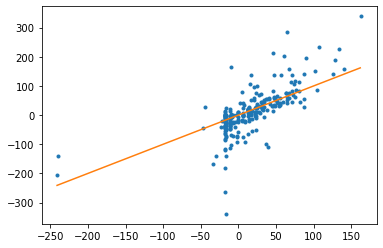

In [9]:
mean_pred_CATE_p = np.mean(pred_CATE_p, axis=1)
base = list(
    range(
        np.min(mean_pred_CATE_p).astype(int),
        np.max(mean_pred_CATE_p).astype(int)
    )
)
plt.plot(mean_pred_CATE_p, Y1-Y0, '.')
plt.plot(base, base)

print("MSE:", np.mean((mean_pred_CATE_p-tau)**2)) # trying to beat 4191.665
print("Bias:", np.mean(mean_pred_CATE_p-tau))


MSE: 2858.6927054744733
Bias: 5.761796717548733


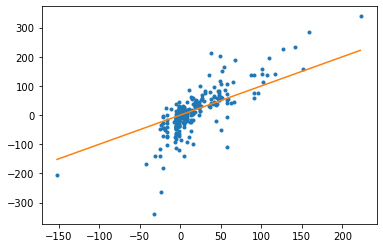

In [10]:
mean_pred_CATE = np.mean(pred_CATE, axis=1)
base = list(
    range(
        np.min(mean_pred_CATE).astype(int),
        np.max(mean_pred_CATE).astype(int)
    )
)
plt.plot(mean_pred_CATE, Y1-Y0, '.')
plt.plot(base, base)

print("MSE:", np.mean((mean_pred_CATE-tau)**2))  # trying to beat 4191.665
print("Bias:", np.mean(mean_pred_CATE-tau))


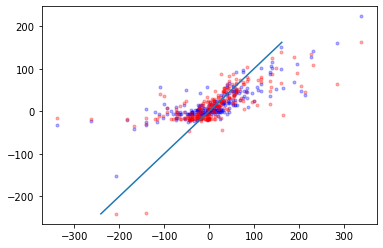

2825.494404060118
3041.482468691099


In [11]:
# Difference in predicted vs actual
plt.plot( tau, pred_CATE, '.', color='blue', alpha=.3)
plt.plot( tau, pred_CATE_p, '.', color='red', alpha=.3)
base = list(
    range(
        np.min(pred_CATE_p).astype(int),
        np.max(pred_CATE_p).astype(int)
    )
)
plt.plot(base, base)
plt.show()
print(np.var(tau - np.mean(pred_CATE, axis=1)))
print(np.var(tau - np.mean(pred_CATE_p, axis=1)))


In [31]:
#Coverage
total_samples = len(model[i]._combine_chains(model[i].extract)['model'])
rep_slot_counter = 0

for i in tqdm(range(N_replications)):
    n_samples = len(model[i]._combine_chains(model[i].extract)['model'])
    if (i==0):
        coverage_matrix=model[i].get_posterior_CATE()
    else:
        coverage_matrix=np.concatenate([coverage_matrix, model[i].get_posterior_CATE()], axis=0)
    
    

100%|██████████| 1/1 [00:00<00:00, 156.57it/s]


In [89]:

q975 = np.quantile( coverage_matrix, q=0.975, axis=0)
q025 = np.quantile( coverage_matrix, q=0.025, axis=0)
U=np.array(tau<q975).astype(int)
L= np.array(q025<tau).astype(int)

sum(U*L)/n


0.484

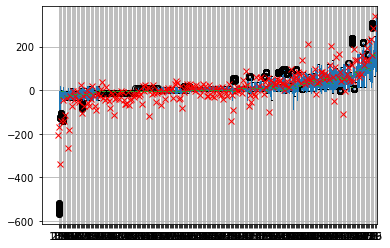

In [62]:
coverage_matrix=pd.DataFrame(coverage_matrix)
index_values=coverage_matrix.mean(axis=0).sort_values().index
temp2 = coverage_matrix.reindex(index_values, axis=1)
_=temp2.boxplot()
_=plt.plot(tau[index_values],'x', color='red')


(-1000.0, 1000.0)

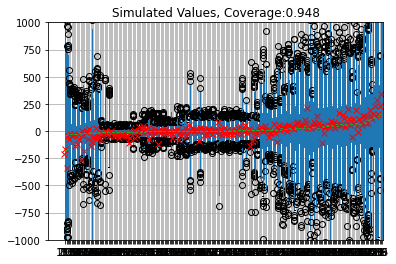

In [93]:
means = np.mean(coverage_matrix, axis=0)
stds = np.std(coverage_matrix, axis=0)*6.23

normal_simulation = pd.DataFrame(np.random.normal(loc=means, scale=stds, size=(1000,n)))
q975 = np.quantile( normal_simulation, q=0.975, axis=0)
q025 = np.quantile( normal_simulation, q=0.025, axis=0)
U=np.array(tau<q975).astype(int)
L= np.array(q025<tau).astype(int)
sum(U*L)/n

coverage_matrix=pd.DataFrame(coverage_matrix)
index_values=normal_simulation.mean(axis=0).sort_values().index
temp3 = normal_simulation.reindex(index_values, axis=1)
_=temp3.boxplot()
_=plt.plot(tau[index_values],'x', color='red')
plt.title("Simulated Values, Coverage:" + str(sum(U*L)/n))
plt.ylim((-1000,1000))

In [94]:
#model._combine_chains(model.extract)

In [18]:
model._combine_chains(model.extract)['in_sample_predictions_g'].shape

enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains


(16, 500)

In [19]:
i=3
values_h = model._combine_chains(model.extract)['model'][i].predict_h(X)
values_g = model._combine_chains(model.extract)['model'][i].predict_g(X)

enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/model.py ModelCGM predict_h
enter bartpy/bartpy/model.py ModelCGM trees_h
-exit bartpy/bartpy/model.py ModelCGM trees_h
type(self.trees_h)= <class 'list'>
enter bartpy/bartpy/model.py ModelCGM _out_of_sample_predict_h
enter bartpy/bartpy/model.py ModelCGM trees_h
-exit bartpy/bartpy/model.py ModelCGM trees_h
-exit bartpy/bartpy/model.py ModelCGM _out_of_sample_predict_h
-exit bartpy/bartpy/model.py ModelCGM predict_h
enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/model.py ModelCGM predict_g
enter bartpy/bartpy/model.py ModelCGM trees_g
-exit bartpy/bartpy/model.py ModelCGM trees_g
type(self.trees_g)= <class 'list'>
enter bartpy/bartpy/model.py ModelCGM _out_of_sample_predict_g
enter bartpy/bartpy/model.py ModelCGM trees_g
-exit bartpy/ba

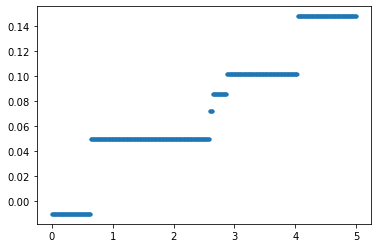

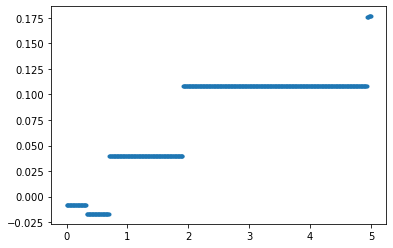

In [20]:
plt.plot(X, values_g,'.')
plt.show()
plt.plot(X, values_h,'.')

In [16]:
L=model._combine_chains(model.extract)['model']
current_unnormalized_value = np.zeros(len(L))
current_value = np.zeros(len(L))
scaling_factor = np.zeros(len(L))
current_unnormalized_value_g = np.zeros(len(L))
current_value_g = np.zeros(len(L))
scaling_factor_g = np.zeros(len(L))
current_unnormalized_value_h = np.zeros(len(L))
current_value_h = np.zeros(len(L))
scaling_factor_h = np.zeros(len(L))

for i in range(len(L)):
    current_unnormalized_value_g[i] = model._combine_chains(model.extract)['model'][i].sigma_g.current_unnormalized_value()
    current_value_g[i] = model._combine_chains(model.extract)['model'][i].sigma_g.current_value()
    scaling_factor_g[i] =model._combine_chains(model.extract)['model'][i].sigma_g.scaling_factor
    
for i in range(len(L)):
    current_unnormalized_value_h[i] = model._combine_chains(model.extract)['model'][i].sigma_h.current_unnormalized_value()
    current_value_h[i] = model._combine_chains(model.extract)['model'][i].sigma_h.current_value()
    scaling_factor_h[i] =model._combine_chains(model.extract)['model'][i].sigma_h.scaling_factor

for i in range(len(L)):
    current_unnormalized_value[i] = model._combine_chains(model.extract)['model'][i].sigma.current_unnormalized_value()
    current_value[i] = model._combine_chains(model.extract)['model'][i].sigma.current_value()
    scaling_factor[i] =model._combine_chains(model.extract)['model'][i].sigma.scaling_factor

enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/model.py ModelCGM sigma_g
-exit bartpy/bartpy/model.py ModelCGM sigma_g
enter bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/model.py ModelCGM sigma_g
-exit bartpy/bartpy/model.py ModelCGM sigma_g
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
en

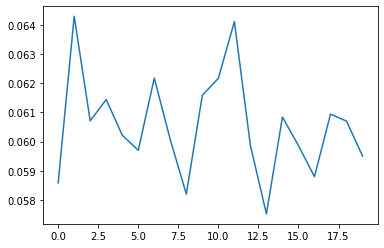

In [17]:
#plt.plot(current_unnormalized_value)
plt.plot(current_value)
#plt.plot(current_value_g)
#plt.plot(current_value_h)
#plt.plot(scaling_factor)

enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains


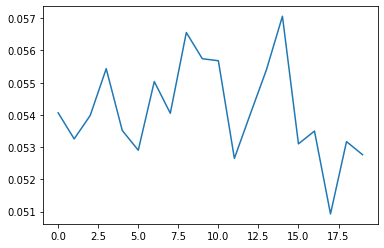

In [18]:
plt.plot(model._combine_chains(model.extract)['in_sample_predictions_g'][:,200])
#plt.ylim((-2,2))

In [24]:
np.median(model._combine_chains(model.extract)['in_sample_predictions_g'][:,200])

enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains


0.08249618936954098

In [25]:
reg_model = SklearnModel(
    n_samples=20,#0,#1000, 
    n_burn=20,#0, 
    n_trees=5,#0,#100, 
    thin=1,
    n_chains=1,
    n_jobs=1,#-1,
    store_in_sample_predictions=True,
)

reg_model.fit(X,y_i_star_standard)
y_pred=reg_model.predict(X)

  0%|          | 0/20 [00:00<?, ?it/s]

enter bartpy/bartpy/sklearnmodel.py SklearnModel __init__
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler __init__
-exit bartpy/bartpy/samplers/leafnode.py LeafNodeSampler __init__
enter bartpy/bartpy/samplers/schedule.py SampleSchedule __init__
-exit bartpy/bartpy/samplers/schedule.py SampleSchedule __init__
-exit bartpy/bartpy/sklearnmodel.py SklearnModel __init__
enter bartpy/bartpy/sklearnmodel.py SklearnModel fit
enter bartpy/bartpy/sklearnmodel.py SklearnModel _construct_model
enter bartpy/bartpy/sklearnmodel.py SklearnModel _convert_covariates_to_data
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _convert_covariates_to_data
enter bartpy/bartpy/sigma.py Sigma __init__
-exit bartpy/bartpy/sigma.py Sigma __init__
enter bartpy/bartpy/model.py Model __init__
in if trees is None
enter bartpy/bartpy/model.py Model initialize_trees
-exit bartpy/bartpy/model.py Model initialize_trees
-exit bartpy/bartpy/model.py Model __init__
-exit bartpy/bartpy/sklearnmodel.py SklearnModel 

 15%|█▌        | 3/20 [00:00<00:00, 20.13it/s]

 UniformTreeMutationLikihoodRatio log_tree_ratio_prune
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_no

enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio_grow
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_tree
enter bartpy/bartpy/samplers/unco

 25%|██▌       | 5/20 [00:00<00:00, 16.80it/s]


-exit bartpy/bartpy/samplers/leafnode.py LeafNodeSampler step
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py UniformMutationProposer propose
enter bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
-exit bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_grow_mutation
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_splittable_leaf_node
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_splittable_leaf_node
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py sample_split_node
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py sample_split_condition
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py sample_split_condition
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py sample_split_node
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_grow_mutation
-exit bartpy/bartpy/samplers/unconstrainedtree/pro

 35%|███▌      | 7/20 [00:00<00:00, 14.65it/s]


enter bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
-exit bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_prune_mutation
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_prunable_decision_node
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_prunable_decision_node
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_prune_mutation
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py UniformMutationProposer propose
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_prune_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter 

enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_prune_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
-exit bartpy/bartpy/samplers/u

 60%|██████    | 12/20 [00:00<00:00, 16.17it/s]

-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio_prune
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio
enter bartpy/bartpy/samplers/scalar.py UniformScalarSampler sample
-exit bartpy/bartpy/samplers/scalar.py UniformScalarSampler sample
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler step
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
enter bartpy/bartpy/model.py Model sigma_m
-exit bartpy/bartpy/model.py Model sigma_m
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/samplers/scalar.py NormalScalarSampler sample
-exit bartpy/bartpy/samplers/scalar.py NormalScalarSampler sample
-exit bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
-exit bartpy/bartpy/samplers/leafnode.py LeafNod

enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler step
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
enter bartpy/bartpy/model.py Model sigma_m
-exit bartpy/bartpy/model.py Model sigma_m
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/samplers/scalar.py NormalScalarSampler sample
-exit bartpy/bartpy/samplers/scalar.py NormalScalarSampler sample
-exit bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
-exit bartpy/bartpy/samplers/leafnode.py LeafNodeSampler step
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler step
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
enter bartpy/bartpy/model.py Model sigma_m
-exit bartpy/bartpy/model.py Model sigma_m
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/sigma.py Sigma current_value
-exit b

 70%|███████   | 14/20 [00:00<00:00, 14.17it/s]


-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_grow_mutation
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py UniformMutationProposer propose
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_grow_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_tree
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/sampl

enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_likihood_ratio_grow
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/model.py Model sigma_m
-exit bartpy/bartpy/model.py Model sigma_m
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_grow_ratio
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_grow_ratio
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_likihood_ratio_grow
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_likihood_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_

 80%|████████  | 16/20 [00:01<00:00, 13.41it/s]


-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_likihood_ratio_grow
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_likihood_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio_grow
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodrat

 90%|█████████ | 18/20 [00:01<00:00, 14.08it/s]


enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_tree
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.

  0%|          | 0/20 [00:00<?, ?it/s]

enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_prune_mutation
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_prunable_decision_node
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_prunable_decision_node
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_prune_mutation
-exit bartpy/bartpy/samplers/unconstrainedtree/proposer.py UniformMutationProposer propose
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_prune_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedt

 20%|██        | 4/20 [00:00<00:00, 17.32it/s]


enter bartpy/bartpy/model.py Model trees
-exit bartpy/bartpy/model.py Model trees
-exit bartpy/bartpy/model.py Model predict
enter bartpy/bartpy/model.py deep_copy_model
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/model.py Model trees
-exit bartpy/bartpy/model.py Model trees
enter bartpy/bartpy/model.py Model __init__
in else trees is not None
-exit bartpy/bartpy/model.py Model __init__
-exit bartpy/bartpy/model.py deep_copy_model
enter bartpy/bartpy/samplers/schedule.py SampleSchedule steps
enter bartpy/bartpy/model.py Model refreshed_trees
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py UniformMutationProposer propose
enter bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
-exit bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_prune_mutation
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_prunable_decision_nod

 40%|████      | 8/20 [00:00<00:00, 18.03it/s]


-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_not_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_node_split
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio_prune
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_tree_ratio
enter bartpy/bartpy/samplers/scalar.py UniformScalarSampler sample
-exit bartpy/bartpy/samplers/scalar.py UniformScalarSampler sample
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler step
enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
enter bartpy/bartpy/model.py Model s

 60%|██████    | 12/20 [00:00<00:00, 15.46it/s]


enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_tree
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_tree
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_grow_transition_ratio
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_likihood_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTre

 70%|███████   | 14/20 [00:00<00:00, 15.43it/s]

enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_prune_transition_ratio
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_likihood_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoo

 90%|█████████ | 18/20 [00:01<00:00, 15.49it/s]


enter bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
enter bartpy/bartpy/model.py Model sigma_m
-exit bartpy/bartpy/model.py Model sigma_m
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/samplers/scalar.py NormalScalarSampler sample
-exit bartpy/bartpy/samplers/scalar.py NormalScalarSampler sample
-exit bartpy/bartpy/samplers/leafnode.py LeafNodeSampler sample
-exit bartpy/bartpy/samplers/leafnode.py LeafNodeSampler step
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py UniformMutationProposer propose
enter bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
-exit bartpy/bartpy/samplers/scalar.py DiscreteSampler sample
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py uniformly_sample_grow_mutation
enter bartpy/bartpy/samplers/unconstrainedtree/proposer.py random_splittable_leaf_node
-exit bartpy/bartpy

100%|██████████| 20/20 [00:01<00:00, 16.24it/s]

UniformTreeMutationLikihoodRatio log_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTreeMutationLikihoodRatio log_grow_transition_ratio
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_prunable_decision_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_tree
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py n_splittable_leaf_nodes
enter bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_node
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py log_probability_split_within_tree
-exit bartpy/bartpy/samplers/unconstrainedtree/likihoodratio.py UniformTree

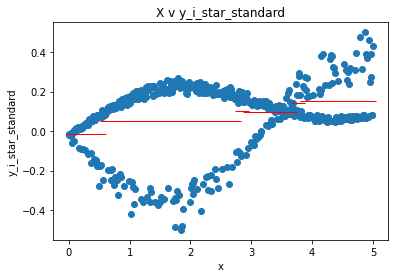

In [26]:
plt.scatter(X[:, 0], y_i_star_standard)
plt.plot(X, y_pred,'_', color='red')
plt.xlabel("x")
plt.ylabel("y_i_star_standard")
plt.title("X v y_i_star_standard")
plt.show()


In [27]:
L=model._combine_chains(reg_model.extract)['model']
current_unnormalized_value = np.zeros(len(L))
current_value = np.zeros(len(L))
scaling_factor = np.zeros(len(L))
for i in range(len(L)):
    current_unnormalized_value[i] = reg_model._combine_chains(reg_model.extract)['model'][i].sigma.current_unnormalized_value()
    current_value[i] = reg_model._combine_chains(reg_model.extract)['model'][i].sigma.current_value()
    scaling_factor[i]= reg_model._combine_chains(reg_model.extract)['model'][i].sigma.scaling_factor
    

enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/model.py Model sigma
-exit bartpy/bartpy/model.py Model sigma
enter bartpy/bartpy/sigma.py Sigma current_value
-exit bartpy/bartpy/sigma.py Sigma current_value
enter bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
-exit bartpy/bartpy/sklearnmodel.py SklearnModel _combine_chains
enter bartpy/bartpy/mo

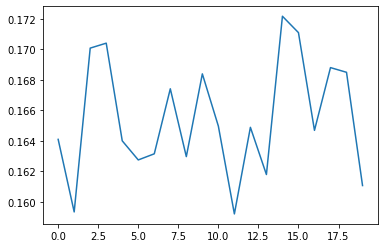

In [28]:
plt.plot(current_value)

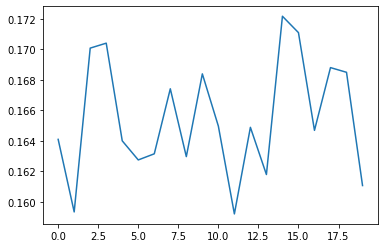

In [29]:
plt.plot(current_unnormalized_value)

In [46]:
#.sigma.current_unnormalized_value()

array([-0.12827331, -0.12827331, -0.12827331, -0.03558977, -0.03926117,
       -0.12827331, -0.21342894, -0.03459578, -0.12827331, -0.12827331,
       -0.12827331, -0.12827331, -0.12827331, -0.21342894, -0.12827331,
       -0.03459578, -0.12827331, -0.12827331, -0.03459578, -0.12827331,
       -0.12827331, -0.03926117,  0.15739767, -0.03459578, -0.12827331,
        0.06838553, -0.03558977, -0.12827331, -0.12827331, -0.12827331,
        0.03651067, -0.12827331, -0.12827331, -0.12827331, -0.12827331,
       -0.12827331, -0.03926117, -0.03558977, -0.12827331, -0.12827331,
       -0.12827331, -0.12827331, -0.12827331, -0.12827331,  0.07224203,
       -0.03459578, -0.00442291, -0.12827331, -0.21342894, -0.03459578,
       -0.12827331, -0.12827331, -0.12827331, -0.12827331, -0.12827331,
       -0.03558977, -0.12827331, -0.12827331, -0.12827331, -0.03926117,
       -0.12827331, -0.12827331, -0.12827331, -0.12827331, -0.12827331,
       -0.21342894, -0.03459578,  0.1470999 , -0.12827331, -0.12

In [44]:
i

2